<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [39]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize

#from shapely.geometry import LineString
#from shapely.geometry import Point

# Some functions

In [ ]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


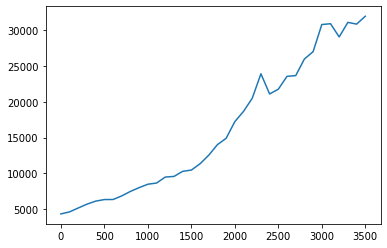

In [ ]:
load_and_plot(time_step=100)

In [ ]:
import pickle 
dbfile = open('ensemble2_100', 'rb')      
systems = pickle.load(dbfile) 

FileNotFoundError: [Errno 2] No such file or directory: 'ensemble2_100'

# Trapezium Billiards

In [40]:
def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    
    p = Point(0,h)
    c = p.buffer(l).boundary

    x_left = -l
    x_right = l
    m = (vel_vec[1]/vel_vec[0])
    k = 1
    while k>0:
        y_left = line2cord(m , x, h, x_left)
        y_right = line2cord(m , x, h, x_right)
        #print((x_left,y_left),(x_right, y_right))
        ls = LineString([Point(x_left,y_left), Point(x_right, y_right)])
        inte = c.intersection(ls)
       
        pois = [inte.geoms[0].coords[0], inte.geoms[1].coords[0]]
        print(pois)
        if (pois[0][1]>h) != (pois[1][1]>h):
            print('1yh')
            if pois[0][1]>h:
                x_ =  pois[0][0]
                y_ = pois[0][1]
            else:
                x_ =  pois[1][0]
                y_ = pois[1][1]
            if (x_ - x)/vel_vec[0]< 0:
                print('t dec: x_ , x, u:', x_, x, vel_vec[0] )
            t += (x_ - x)/vel_vec[0]
            x = x_
            y = y_
            if k>0:
                k = -2
                

        elif (pois[0][1]>h and pois[1][1]>h) and (k>0):
            print('2yh')
            #collision inside
            sol1 = pois[0][0]
            sol2 = pois[1][0]
            if x == sol1:
                t += (x - sol2)/vel_vec[0]
                x = sol2
                y = pois[1][1]
            elif x == sol2:
                t += (x - sol1)/vel_vec[0]
                x = sol1
                y = pois[0][1]
            else:
                print('no intersection')


        else:
            #error
            print('err3')

        p = float(d_sem_func(x, r))
        nor_vec = [-np.sign(p), -np.sign(p)*(1/p)]
        nor_vec = normalize(nor_vec)
        #nor_inc = normalize(vel_vec)
        ref = vel_vec - (2*np.dot(nor_inc, vel_vec)*nor_vec)
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        
        if np.linalg.norm(ref) != np.linalg.norm(vel_vec):
            print('unnormalized collision')
        if k== -2:
            if ref[1]>0:
                print('other way')
            del_t = ((h-y)/ref[1])
            if del_t < 0:
                print('t dec_2: y:', y, 'h:', h, 'v:', ref[1])
            print('v')
            t += del_t
            x += ref[0]*del_t
            y = h
            if abs(x) > l:
                print('x:', x, 'x_:', x_)
            return (x, y, ref[0], ref[1], t)
        k += 1
        m = ref[1]/ref[0]

#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    print('t_left:',time_step[0], 't_right:',time_step[1], 
           't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            yf = -h
            vf = -v
            uf = u
            xf = x + u*time_step[di]
            #print('next wall: bottom')
    
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10)
plot_bill(res)


    


t_left: -8.09629893137039 t_right: 16.81539008823081 t_top: 0.25063589562403643 t_bottom: -0.05316518998085621
next wall: semi-circle enclosure


NameError: name 'Point' is not defined

In [ ]:
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


# Stadium Billiards

In [43]:
k = d_sem_func(x = 1, r = 2)
nor_vec = [-np.sign(k), -np.sign(k)*(1/k)]
nor_vec = normalize(nor_vec)
nor_vec 

array([-0.5      , -0.8660254])

In [21]:
x = -23
np.sign(x)

-1

t_left: -8.09629893137039 t_right: 16.81539008823081 t_top: 0.25063589562403643 t_bottom: -0.05316518998085621
next wall: semi-circle enclosure
entered enclosure: x: -0.6597560975609755 y: 1 u: 0.16056719385235946 v: 6.583254947946738
x: -0.6597560975609755 y: 1
disc: 23985.19000000041
sol1: -0.705401762010272 sol2: -0.6133259431026886
ysol1: -0.8714722424211572 ysol2: 2.9036363327897634
first collision
p: -0.3221865082832652
nor vec: [ 1.         -3.10379229]
ref: [[ 3.97350519]
 [-5.2513126 ]] ref shape: (2, 1)
x: -0.6133259431026886 y: 2.9036363327897634 vel_vec: [[ 3.97350519]
 [-5.2513126 ]] m: [-1.32158192]
x: -0.6133259431026886 y: 2.9036363327897634
disc: [39.16600085]
sol1: [-0.61332594] sol2: [1.66524501]
ysol1: [2.90363633] ysol2: [-0.10768184]
last collision
exit enclosure: x: [0.82709656] y: 1 u: [3.97350519] v: [-5.2513126]
t_left: [-0.71148682] t_right: [0.29518105] t_top: [-0.] t_bottom: [0.38085716]
t_left: [1.00666787] t_right: [-0.] t_top: [-0.29518105] t_bottom: [0.

t_left: [0.79214301] t_right: [-0.4219568] t_top: [0.35076659] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [-0.54583151] y: 1 u: [-3.29462205] v: [5.70179736]
x: [-0.54583151] y: 1
disc: [60.35236002]
sol1: [-1.38148059] sol2: [0.56306757]
ysol1: [2.44620586] ysol2: [-0.91910263]
first collision
p: -0.9552447776742902
nor vec: [ 1.        -1.0468521]
ref: [[ 5.54507794]
 [-3.55206112]] ref shape: (2, 1)
x: [-1.38148059] y: [2.44620586] vel_vec: [[ 5.54507794]
 [-3.55206112]] m: [-0.64057912]
x: [-1.38148059] y: [2.44620586]
disc: [21.30542241]
sol1: [-1.38148059] sol2: [1.89132914]
ysol1: [2.44620586] ysol2: [0.34971229]
last collision
exit enclosure: x: [0.87617318] y: 1 u: [5.54507794] v: [-3.55206112]
t_left: [-0.51868941] t_right: [0.20267106] t_top: [-0.] t_bottom: [0.56305337]
t_left: [0.72136047] t_right: [-0.] t_top: [-0.20267106] t_bottom: [0.36038231]
t_left: [0.36097815] t_right: [-0.36038231] t_top: [0.56305337] t_bottom: [0.]
t_left: [0.] t_right:

disc: [16.39714634]
sol1: [-1.99822801] sol2: [1.68740134]
ysol1: [0.91582864] ysol2: [2.07362784]
last collision
exit enclosure: x: [-1.73028481] y: 1 u: [-6.28251557] v: [-1.97358193]
t_left: [0.04293108] t_right: [-0.59375656] t_top: [-0.] t_bottom: [1.01338585]
t_left: [0.] t_right: [0.63668764] t_top: [-0.04293108] t_bottom: [0.97045477]
t_left: [0.63668764] t_right: [-0.] t_top: [-0.67961872] t_bottom: [0.33376713]
t_left: [0.30292051] t_right: [-0.33376713] t_top: [1.01338585] t_bottom: [0.]
t_left: [0.] t_right: [0.63668764] t_top: [0.71046534] t_bottom: [-0.30292051]
t_left: [0.63668764] t_right: [-0.] t_top: [0.0737777] t_bottom: [-0.93960815]
next wall: semi-circle enclosure
entered enclosure: x: [1.53649043] y: 1 u: [-6.28251557] v: [1.97358193]
x: [1.53649043] y: 1
disc: [16.64704481]
sol1: [-1.71879733] sol2: [1.99481098]
ysol1: [2.02261221] ysol2: [0.85602373]
first collision
p: -1.6807909448986833
nor vec: [ 1.         -0.59495799]
ref: [[ 4.73203619]
 [-4.57961363]] re

entered enclosure: x: [0.63049082] y: 1 u: [1.49748921] v: [6.41268693]
x: [0.63049082] y: 1
disc: [280.24963845]
sol1: [0.16504423] sol2: [1.03073006]
ysol1: [-0.99317847] ysol2: [2.71394152]
first collision
p: 0.6013799455899355
nor vec: [-1.         -1.66284228]
ref: [[-4.96234218]
 [-4.32899383]] ref shape: (2, 1)
x: [1.03073006] y: [2.71394152] vel_vec: [[-4.96234218]
 [-4.32899383]] m: [0.87236907]
x: [1.03073006] y: [2.71394152]
disc: [25.52107995]
sol1: [-1.83795792] sol2: [1.03073006]
ysol1: [0.21138686] ysol2: [2.71394152]
last collision
exit enclosure: x: [-0.93396766] y: 1 u: [-4.96234218] v: [-4.32899383]
t_left: [0.21482443] t_right: [-0.59124654] t_top: [-0.] t_bottom: [0.46200112]
t_left: [0.] t_right: [0.80607097] t_top: [-0.21482443] t_bottom: [0.24717669]
t_left: [-0.24717669] t_right: [0.55889429] t_top: [0.46200112] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [1.51918295] y: 1 u: [4.96234218] v: [4.32899383]
x: [1.51918295] y: 1
disc: [21.

exit enclosure: x: [-1.7077379] y: 1 u: [5.0649447] v: [-4.20848699]
t_left: [-0.05770292] t_right: [0.73203917] t_top: [-0.] t_bottom: [0.47523017]
t_left: [-0.53293309] t_right: [0.25680899] t_top: [0.47523017] t_bottom: [0.]
t_left: [0.78974209] t_right: [-0.] t_top: [0.21842118] t_bottom: [-0.25680899]
next wall: semi-circle enclosure
entered enclosure: x: [0.8937088] y: 1 u: [-5.0649447] v: [4.20848699]
x: [0.8937088] y: 1
disc: [24.8407037]
sol1: [-1.10920506] sol2: [1.83923115]
ysol1: [2.66423079] ysol2: [0.21436092]
first collision
p: -0.6664971410646353
nor vec: [ 1.         -1.50038153]
ref: [[ 1.93522402]
 [-6.29443687]] ref shape: (2, 1)
x: [-1.10920506] y: [2.66423079] vel_vec: [[ 1.93522402]
 [-6.29443687]] m: [-3.25256239]
x: [-1.10920506] y: [2.66423079]
disc: [170.15739114]
sol1: [-1.10920506] sol2: [0.01733924]
ysol1: [2.66423079] ysol2: [-0.99992484]
last collision
exit enclosure: x: [-0.59753746] y: 1 u: [1.93522402] v: [-6.29443687]
t_left: [-0.72470294] t_right: [

t_left: [-0.19846037] t_right: [0.67887682] t_top: [0.42090563] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [0.82384475] y: 1 u: [4.55925051] v: [4.7516589]
x: [0.82384475] y: 1
disc: [30.43009081]
sol1: [-0.8931743] sol2: [1.75105375]
ysol1: [-0.78948028] ysol2: [1.96633885]
first collision
p: 1.8120494134344018
nor vec: [-1.         -0.55186133]
ref: [[-6.45067967]
 [-1.32429581]] ref shape: (2, 1)
x: [1.75105375] y: [1.96633885] vel_vec: [[-6.45067967]
 [-1.32429581]] m: [0.20529555]
x: [1.75105375] y: [1.96633885]
disc: [15.20124669]
sol1: [-1.99014628] sol2: [1.75105375]
ysol1: [1.19828715] ysol2: [1.96633885]
p: -10.03668829163441
nor vec: [ 1.         -0.09963446]
ref: [[ 6.06256934]
 [-2.57104659]] ref shape: (2, 1)
x: [-1.99014628] y: [1.19828715] vel_vec: [[ 6.06256934]
 [-2.57104659]] m: [-0.42408531]
x: [-1.99014628] y: [1.19828715]
disc: [17.20983559]
sol1: [-1.99014628] sol2: [1.52596144]
ysol1: [1.19828715] ysol2: [-0.29284248]
last collision
ex

t_left: [0.9938158] t_right: [-1.51890465] t_top: [0.31299372] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [-0.91619924] y: 1 u: [-1.59190013] v: [6.38990466]
x: [-0.91619924] y: 1
disc: [219.69658825]
sol1: [-1.29574433] sol2: [-0.42957328]
ysol1: [2.52349816] ysol2: [-0.95332199]
first collision
p: -0.8505060039438667
nor vec: [ 1.         -1.17577065]
ref: [[ 6.05150359]
 [-2.59698513]] ref shape: (2, 1)
x: [-1.29574433] y: [2.52349816] vel_vec: [[ 6.05150359]
 [-2.59698513]] m: [-0.42914709]
x: [-1.29574433] y: [2.52349816]
disc: [15.20296714]
sol1: [-1.29574433] sol2: [1.99694793]
ysol1: [2.52349816] ysol2: [1.11044887]
p: 18.08029343113308
nor vec: [-1.         -0.05530884]
ref: [[-5.72819624]
 [-3.24850663]] ref shape: (2, 1)
x: [1.99694793] y: [1.11044887] vel_vec: [[-5.72819624]
 [-3.24850663]] m: [0.56710812]
x: [1.99694793] y: [1.11044887]
disc: [16.96755133]
sol1: [-1.11982911] sol2: [1.99694793]
ysol1: [-0.65710071] ysol2: [1.11044887]
last collis

t_left: [0.67404769] t_right: [-0.] t_top: [0.50079429] t_bottom: [-0.19981245]
next wall: semi-circle enclosure
entered enclosure: x: [-0.97186264] y: 1 u: [-5.9342982] v: [2.85466853]
x: [-0.97186264] y: 1
disc: [18.82821555]
sol1: [-1.94450121] sol2: [1.57923741]
ysol1: [1.46788358] ysol2: [-0.22719566]
first collision
p: -4.155950924276517
nor vec: [ 1.         -0.24061882]
ref: [[ 6.5833336 ]
 [-0.15730925]] ref shape: (2, 1)
x: [-1.94450121] y: [1.46788358] vel_vec: [[ 6.5833336 ]
 [-0.15730925]] m: [-0.02389507]
x: [-1.94450121] y: [1.46788358]
disc: [15.29875774]
sol1: [-1.94450121] sol2: [1.96462942]
ysol1: [1.46788358] ysol2: [1.37447462]
p: 5.246362070679522
nor vec: [-1.         -0.19060827]
ref: [[-6.06387258]
 [-2.56797134]] ref shape: (2, 1)
x: [1.96462942] y: [1.37447462] vel_vec: [[-6.06387258]
 [-2.56797134]] m: [0.42348702]
x: [1.96462942] y: [1.37447462]
disc: [18.03216029]
sol1: [-1.63604943] sol2: [1.96462942]
ysol1: [-0.15036615] ysol2: [1.37447462]
last collisio

exit enclosure: x: [-1.2529761] y: 1 u: [-0.31900411] v: [-6.57748158]
t_left: [2.34173751] t_right: [-10.19728575] t_top: [-0.] t_bottom: [0.30406775]
t_left: [2.03766976] t_right: [-10.50135349] t_top: [0.30406775] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [-1.44697383] y: 1 u: [-0.31900411] v: [6.57748158]
x: [-1.44697383] y: 1
disc: [3257.68175631]
sol1: [-1.51054778] sol2: [-1.37660872]
ysol1: [2.3108186] ysol2: [-0.45084405]
first collision
p: -1.1523698123883794
nor vec: [ 1.         -0.86777698]
ref: [[6.55682521]
 [0.61079515]] ref shape: (2, 1)
x: [-1.51054778] y: [2.3108186] vel_vec: [[6.55682521]
 [0.61079515]] m: [0.0931541]
x: [-1.51054778] y: [2.3108186]
disc: [7.71105872]
sol1: [-1.51054778] sol2: [1.24244195]
ysol1: [2.3108186] ysol2: [2.56727088]
p: 0.7927423185524152
nor vec: [-1.         -1.26144395]
ref: [[ 0.90138095]
 [-6.52323079]] ref shape: (2, 1)
x: [1.24244195] y: [2.56727088] vel_vec: [[ 0.90138095]
 [-6.52323079]] m: [-7.2369299

x: [-1.98174609] y: [1.26959681] vel_vec: [[ 6.15396608]
 [-2.34387051]] m: [-0.38087154]
x: [-1.98174609] y: [1.26959681]
disc: [17.37935767]
sol1: [-1.98174609] sol2: [1.65897518]
ysol1: [1.26959681] ysol2: [-0.11705029]
last collision
exit enclosure: x: [-1.27390424] y: 1 u: [6.15396608] v: [-2.34387051]
t_left: [-0.11798826] t_right: [0.53199907] t_top: [-0.] t_bottom: [0.85328946]
t_left: [0.64998733] t_right: [-0.] t_top: [-0.53199907] t_bottom: [0.32129039]
t_left: [0.32869695] t_right: [-0.32129039] t_top: [0.85328946] t_bottom: [0.]
t_left: [0.] t_right: [0.64998733] t_top: [0.52459251] t_bottom: [-0.32869695]
next wall: semi-circle enclosure
entered enclosure: x: [1.22832453] y: 1 u: [6.15396608] v: [2.34387051]
x: [1.22832453] y: 1
disc: [17.44553598]
sol1: [-1.66821203] sol2: [1.97943434]
ysol1: [-0.10320833] ysol2: [1.28607635]
first collision
p: 6.919252029298174
nor vec: [-1.         -0.14452429]
ref: [[-6.5657778 ]
 [ 0.50555853]] ref shape: (2, 1)
x: [1.97943434] y: [1

x: [1.98741376] y: [1.22402357]
disc: [12.88957058]
sol1: [-0.07957696] sol2: [1.98741376]
ysol1: [2.99841625] ysol2: [1.22402357]
p: -0.0398200107547079
nor vec: [  1.         -25.11300176]
ref: [[-4.63977301]
 [-4.67306472]] ref shape: (2, 1)
x: [-0.07957696] y: [2.99841625] vel_vec: [[-4.63977301]
 [-4.67306472]] m: [1.00717529]
x: [-0.07957696] y: [2.99841625]
disc: [14.94871655]
sol1: [-1.99893411] sol2: [-0.07957696]
ysol1: [1.06528715] ysol2: [2.99841625]
p: -30.617572430888835
nor vec: [ 1.         -0.03266098]
ref: [[ 4.32495621]
 [-4.96586159]] ref shape: (2, 1)
x: [-1.99893411] y: [1.06528715] vel_vec: [[ 4.32495621]
 [-4.96586159]] m: [-1.14818772]
x: [-1.99893411] y: [1.06528715]
disc: [17.20417879]
sol1: [-1.99893411] sol2: [-0.20980873]
ysol1: [1.06528715] ysol2: [-0.98896463]
last collision
exit enclosure: x: [-1.94207307] y: 1 u: [4.32495621] v: [-4.96586159]
t_left: [-0.01339365] t_right: [0.91147121] t_top: [-0.] t_bottom: [0.40274985]
t_left: [-0.41614349] t_right: 

last collision
exit enclosure: x: [1.39242009] y: 1 u: [0.52437133] v: [-6.56430211]
t_left: [-6.4694996] t_right: [1.15868255] t_top: [-0.] t_bottom: [0.30467824]
t_left: [-6.77417784] t_right: [0.85400432] t_top: [0.30467824] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [1.71194915] y: 1 u: [0.52437133] v: [6.56430211]
x: [1.71194915] y: 1
disc: [686.24010791]
sol1: [1.6180429] sol2: [1.78414545]
ysol1: [-0.17555824] ysol2: [1.90378373]
first collision
p: 1.9740845012639252
nor vec: [-1.         -0.50656393]
ref: [[-5.60261977]
 [ 3.46058943]] ref shape: (2, 1)
x: [1.78414545] y: [1.90378373] vel_vec: [[-5.60261977]
 [ 3.46058943]] m: [-0.61767344]
x: [1.78414545] y: [1.90378373]
disc: [6.01134523]
sol1: [0.00943091] sol2: [1.78414545]
ysol1: [2.99997776] ysol2: [1.90378373]
p: 0.004715505160009278
nor vec: [  -1.         -212.06635685]
ref: [[-5.63500675]
 [-3.40759835]] ref shape: (2, 1)
x: [0.00943091] y: [2.99997776] vel_vec: [[-5.63500675]
 [-3.40759835]

 [ 3.87387413]] m: [-0.72745601]
x: [1.67845794] y: [2.08755641]
disc: [3.14926544]
sol1: [0.51796488] sol2: [1.67845794]
ysol1: [2.93176406] ysol2: [2.08755641]
p: 0.2681305091702505
nor vec: [-1.        -3.7295271]
ref: [[-6.5489596 ]
 [-0.69004031]] ref shape: (2, 1)
x: [0.51796488] y: [2.93176406] vel_vec: [[-6.5489596 ]
 [-0.69004031]] m: [0.1053664]
x: [0.51796488] y: [2.93176406]
disc: [2.08229465]
sol1: [-0.90920637] sol2: [0.51796488]
ysol1: [2.78138816] ysol2: [2.93176406]
p: -0.5103920584588022
nor vec: [ 1.         -1.95927813]
ref: [[-4.40090221]
 [-4.8986822 ]] ref shape: (2, 1)
x: [-0.90920637] y: [2.78138816] vel_vec: [[-4.40090221]
 [-4.8986822 ]] m: [1.11310862]
x: [-0.90920637] y: [2.78138816]
disc: [4.61108758]
sol1: [-1.86826575] sol2: [-0.90920637]
ysol1: [1.7138509] ysol2: [2.78138816]
p: -2.617165222327155
nor vec: [ 1.        -0.3820928]
ref: [[ 0.01299346]
 [-6.58519997]] ref shape: (2, 1)
x: [-1.86826575] y: [1.7138509] vel_vec: [[ 0.01299346]
 [-6.58519997]]

exit enclosure: x: [1.89920471] y: 1 u: [-0.66858602] v: [-6.55118465]
t_left: [5.83201651] t_right: [-0.15075889] t_top: [-0.] t_bottom: [0.3052883]
t_left: [5.52672821] t_right: [-0.45604719] t_top: [0.3052883] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [1.49098174] y: 1 u: [-0.66858602] v: [6.55118465]
x: [1.49098174] y: 1
disc: [698.44244364]
sol1: [1.33940228] sol2: [1.61182308]
ysol1: [2.48526144] ysol2: [-0.18407194]
first collision
p: 0.9017956310418789
nor vec: [-1.        -1.1088987]
ref: [[-6.58520558]
 [-0.00974707]] ref shape: (2, 1)
x: [1.33940228] y: [2.48526144] vel_vec: [[-6.58520558]
 [-0.00974707]] m: [0.00148015]
x: [1.33940228] y: [2.48526144]
disc: [7.19956956]
sol1: [-1.34379321] sol2: [1.33940228]
ysol1: [2.48128992] ysol2: [2.48526144]
p: -0.9071777204063891
nor vec: [ 1.         -1.10231984]
ref: [[-0.6491897 ]
 [-6.55313515]] ref shape: (2, 1)
x: [-1.34379321] y: [2.48128992] vel_vec: [[-0.6491897 ]
 [-6.55313515]] m: [10.0943301]
x

exit enclosure: x: [1.12159704] y: 1 u: [6.1322697] v: [-2.40006163]
t_left: [-0.50904432] t_right: [0.14324271] t_top: [-0.] t_bottom: [0.83331194]
t_left: [0.65228703] t_right: [-0.] t_top: [-0.14324271] t_bottom: [0.69006922]
t_left: [0.] t_right: [0.65228703] t_top: [-0.79552975] t_bottom: [0.03778219]
t_left: [-0.03778219] t_right: [0.61450484] t_top: [0.83331194] t_bottom: [0.]
t_left: [0.65228703] t_right: [-0.] t_top: [0.21880709] t_bottom: [-0.61450484]
next wall: semi-circle enclosure
entered enclosure: x: [0.65821588] y: 1 u: [-6.1322697] v: [2.40006163]
x: [0.65821588] y: 1
disc: [18.18542133]
sol1: [-1.76155735] sol2: [1.9364226]
ysol1: [1.94705634] ysol2: [0.49973256]
first collision
p: -1.8600343845991067
nor vec: [ 1.         -0.53762447]
ref: [[ 5.38420947]
 [-3.79147938]] ref shape: (2, 1)
x: [-1.76155735] y: [1.94705634] vel_vec: [[ 5.38420947]
 [-3.79147938]] m: [-0.70418497]
x: [-1.76155735] y: [1.94705634]
disc: [23.58967553]
sol1: [-1.76155735] sol2: [1.48531528]

ysol1: [2.80494897] ysol2: [-0.99801275]
last collision
exit enclosure: x: [-0.49491568] y: 1 u: [1.31064829] v: [-6.4534664]
t_left: [-1.14835104] t_right: [1.90357375] t_top: [-0.] t_bottom: [0.30991096]
t_left: [-1.458262] t_right: [1.59366278] t_top: [0.30991096] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [0.31745288] y: 1 u: [1.31064829] v: [6.4534664]
x: [0.31745288] y: 1
disc: [394.13938695]
sol1: [-0.08833502] sol2: [0.69809054]
ysol1: [-0.99804828] ysol2: [2.87421173]
first collision
p: 0.372471547625299
nor vec: [-1.         -2.68476883]
ref: [[-3.23047033]
 [-5.73838731]] ref shape: (2, 1)
x: [0.69809054] y: [2.87421173] vel_vec: [[-3.23047033]
 [-5.73838731]] m: [1.77633184]
x: [0.69809054] y: [2.87421173]
disc: [64.87698422]
sol1: [-1.24028184] sol2: [0.69809054]
ysol1: [-0.56898086] ysol2: [2.87421173]
last collision
exit enclosure: x: [-0.35701171] y: 1 u: [-3.23047033] v: [-5.73838731]
t_left: [0.50859105] t_right: [-0.72961875] t_top: [-0.] t

t_left: [0.71952684] t_right: [-0.42994505] t_top: [-0.] t_bottom: [0.35773877]
t_left: [0.36178807] t_right: [-0.78768382] t_top: [0.35773877] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [-1.98590901] y: 1 u: [-3.47985891] v: [5.59067165]
x: [-1.98590901] y: 1
disc: [16.57987394]
sol1: [-1.99987415] sol2: [-0.86283804]
ysol1: [1.02243612] ysol2: [-0.80430333]
first collision
p: -89.1363763894204
nor vec: [ 1.         -0.01121876]
ref: [[3.60440814]
 [5.51119493]] ref shape: (2, 1)
x: [-1.99987415] y: [1.02243612] vel_vec: [[3.60440814]
 [5.51119493]] m: [1.52901523]
x: [-1.99987415] y: [1.02243612]
disc: [15.45384577]
sol1: [-1.99987415] sol2: [-0.82214186]
ysol1: [1.02243612] ysol2: [2.82320673]
p: -0.4509317824024855
nor vec: [ 1.         -2.21763034]
ref: [[ 6.51672763]
 [-0.94725313]] ref shape: (2, 1)
x: [-0.82214186] y: [2.82320673] vel_vec: [[ 6.51672763]
 [-0.94725313]] m: [-0.14535718]
x: [-0.82214186] y: [2.82320673]
disc: [4.72765043]
sol1: [-0.822

t_left: [0.99945045] t_right: [-0.14111876] t_top: [-0.] t_bottom: [0.3588298]
t_left: [0.64062065] t_right: [-0.49994855] t_top: [0.3588298] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [-1.01175359] y: 1 u: [-3.50702086] v: [5.57367313]
x: [-1.01175359] y: 1
disc: [46.0712143]
sol1: [-1.68734681] sol2: [0.23774702]
ysol1: [2.07371353] ysol2: [-0.98581881]
first collision
p: -1.5715055831616578
nor vec: [ 1.         -0.63633245]
ref: [[ 6.53445485]
 [-0.81604372]] ref shape: (2, 1)
x: [-1.68734681] y: [2.07371353] vel_vec: [[ 6.53445485]
 [-0.81604372]] m: [-0.12488321]
x: [-1.68734681] y: [2.07371353]
disc: [13.27051065]
sol1: [-1.68734681] sol2: [1.8995833]
ysol1: [2.07371353] ysol2: [1.62576617]
p: 3.035611990222166
nor vec: [-1.         -0.32942287]
ref: [[-4.77004961]
 [-4.54000597]] ref shape: (2, 1)
x: [1.8995833] y: [1.62576617] vel_vec: [[-4.77004961]
 [-4.54000597]] m: [0.95177332]
x: [1.8995833] y: [1.62576617]
disc: [24.90351019]
sol1: [-0.71881946

x: [1.57116131] y: [2.23751854] vel_vec: [[-4.34744833]
 [-4.94618242]] m: [1.13772081]
x: [1.57116131] y: [2.23751854]
disc: [35.50043088]
sol1: [-1.02568379] sol2: [1.57116131]
ysol1: [-0.71696615] ysol2: [2.23751854]
last collision
exit enclosure: x: [0.48344406] y: 1 u: [-4.34744833] v: [-4.94618242]
t_left: [0.57124177] t_right: [-0.34883817] t_top: [-0.] t_bottom: [0.40435225]
t_left: [0.16688951] t_right: [-0.75319043] t_top: [0.40435225] t_bottom: [0.]
t_left: [0.] t_right: [0.92007994] t_top: [0.23746274] t_bottom: [-0.16688951]
next wall: semi-circle enclosure
entered enclosure: x: [-0.96764302] y: 1 u: [4.34744833] v: [4.94618242]
x: [-0.96764302] y: 1
disc: [31.86254801]
sol1: [-1.77600076] sol2: [0.68419396]
ysol1: [0.08031457] ysol2: [2.8793293]
first collision
p: 0.36406284134667666
nor vec: [-1.         -2.74677854]
ref: [[ 0.14991718]
 [-6.58350609]] ref shape: (2, 1)
x: [0.68419396] y: [2.8793293] vel_vec: [[ 0.14991718]
 [-6.58350609]] m: [-43.91428838]
x: [0.6841939

entered enclosure: x: [-1.27309229] y: 1 u: [-3.66973608] v: [5.46791227]
x: [-1.27309229] y: 1
disc: [37.12861015]
sol1: [-1.82387263] sol2: [0.06840295]
ysol1: [1.82066353] ysol2: [-0.99882992]
first collision
p: -2.2224365471851475
nor vec: [ 1.        -0.4499566]
ref: [[6.52611991]
 [0.88021954]] ref shape: (2, 1)
x: [-1.82387263] y: [1.82066353] vel_vec: [[6.52611991]
 [0.88021954]] m: [0.1348764]
x: [-1.82387263] y: [1.82066353]
disc: [11.74000436]
sol1: [-1.82387263] sol2: [1.54127872]
ysol1: [1.82066353] ysol2: [2.27454302]
p: 1.2092794763030805
nor vec: [-1.        -0.8269387]
ref: [[-2.08997291]
 [-6.24476107]] ref shape: (2, 1)
x: [1.54127872] y: [2.27454302] vel_vec: [[-2.08997291]
 [-6.24476107]] m: [2.98796269]
x: [1.54127872] y: [2.27454302]
disc: [114.47141335]
sol1: [0.46359776] sol2: [1.54127872]
ysol1: [-0.94552746] ysol2: [2.27454302]
last collision
exit enclosure: x: [1.1147195] y: 1 u: [-2.08997291] v: [-6.24476107]
t_left: [1.49031573] t_right: [-0.42358468] t_to

x: [-1.02266682] y: [2.71876484] vel_vec: [[ 0.89278896]
 [-6.52441226]] m: [-7.30789979]
x: [-1.02266682] y: [2.71876484]
disc: [738.01633275]
sol1: [-1.02266682] sol2: [-0.523333]
ysol1: [2.71876484] ysol2: [-0.9303167]
last collision
exit enclosure: x: [-0.7874741] y: 1 u: [0.89278896] v: [-6.52441226]
t_left: [-1.35813271] t_right: [3.12220942] t_top: [-0.] t_bottom: [0.30654102]
t_left: [-1.66467374] t_right: [2.81566839] t_top: [0.30654102] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [-0.24012122] y: 1 u: [0.89278896] v: [6.52441226]
x: [-0.24012122] y: 1
disc: [858.16935132]
sol1: [-0.50493212] sol2: [0.03351679]
ysol1: [-0.9352115] ysol2: [2.99971914]
first collision
p: 0.016760746253554885
nor vec: [ -1.         -59.66321457]
ref: [[ 0.67364088]
 [-6.5506668 ]] ref shape: (2, 1)
x: [0.03351679] y: [2.99971914] vel_vec: [[ 0.67364088]
 [-6.5506668 ]] m: [-9.72427149]
x: [0.03351679] y: [2.99971914]
disc: [1507.34878766]
sol1: [0.03351679] sol2: [0.4397

t_left: [0.] t_right: [0.71335064] t_top: [-0.27976082] t_bottom: [0.2994566]
t_left: [-0.2994566] t_right: [0.41389404] t_top: [0.57921742] t_bottom: [0.]
t_left: [0.71335064] t_right: [-0.] t_top: [0.16532338] t_bottom: [-0.41389404]
next wall: semi-circle enclosure
entered enclosure: x: [1.07297547] y: 1 u: [-5.60734061] v: [3.45293481]
x: [1.07297547] y: 1
disc: [20.32088983]
sol1: [-1.33923583] sol2: [1.9292425]
ysol1: [2.48541153] ysol2: [0.47272077]
first collision
p: -0.901592456947673
nor vec: [ 1.         -1.10914859]
ref: [[ 2.85567936]
 [-5.93381184]] ref shape: (2, 1)
x: [-1.33923583] y: [2.48541153] vel_vec: [[ 2.85567936]
 [-5.93381184]] m: [-2.07789849]
x: [-1.33923583] y: [2.48541153]
disc: [78.34976723]
sol1: [-1.33923583] sol2: [0.32531904]
ysol1: [2.48541153] ysol2: [-0.97336452]
last collision
exit enclosure: x: [-0.62437342] y: 1 u: [2.85567936] v: [-5.93381184]
t_left: [-0.48171605] t_right: [0.91900143] t_top: [-0.] t_bottom: [0.33705147]
t_left: [-0.81876752] t

x: [-1.99835322] y: [1.08114447] vel_vec: [[ 6.48894517]
 [-1.1218815 ]] m: [-0.1728912]
x: [-1.99835322] y: [1.08114447]
disc: [16.19873138]
sol1: [-1.99835322] sol2: [1.90959756]
ysol1: [1.08114447] ysol2: [0.40549418]
last collision
exit enclosure: x: [-1.52901485] y: 1 u: [6.48894517] v: [-1.1218815]
t_left: [-0.0725827] t_right: [0.54385031] t_top: [-0.] t_bottom: [1.78271948]
t_left: [0.61643301] t_right: [-0.] t_top: [-0.54385031] t_bottom: [1.23886917]
t_left: [0.] t_right: [0.61643301] t_top: [-1.16028332] t_bottom: [0.62243616]
t_left: [0.61643301] t_right: [-0.] t_top: [-1.77671633] t_bottom: [0.00600315]
t_left: [0.61042986] t_right: [-0.00600315] t_top: [1.78271948] t_bottom: [0.]
t_left: [0.] t_right: [0.61643301] t_top: [1.17228962] t_bottom: [-0.61042986]
t_left: [0.61643301] t_right: [-0.] t_top: [0.55585661] t_bottom: [-1.22686287]
next wall: semi-circle enclosure
entered enclosure: x: [-1.60692304] y: 1 u: [-6.48894517] v: [1.1218815]
x: [-1.60692304] y: 1
disc: [16.

ysol1: [0.85371956] ysol2: [2.72695739]
last collision
exit enclosure: x: [-1.91765691] y: 1 u: [-3.0669372] v: [-5.82742857]
t_left: [0.02684864] t_right: [-1.27738413] t_top: [-0.] t_bottom: [0.34320455]
t_left: [0.] t_right: [1.30423277] t_top: [-0.02684864] t_bottom: [0.31635591]
t_left: [-0.31635591] t_right: [0.98787686] t_top: [0.34320455] t_bottom: [0.]
next wall: semi-circle enclosure
entered enclosure: x: [0.02283051] y: 1 u: [3.0669372] v: [5.82742857]
x: [0.02283051] y: 1
disc: [73.75738717]
sol1: [-0.91353586] sol2: [0.94929276]
ysol1: [-0.77917178] ysol2: [2.76035316]
first collision
p: 0.5392626777569174
nor vec: [-1.         -1.85438385]
ref: [[-3.18403867]
 [-5.76428012]] ref shape: (2, 1)
x: [0.94929276] y: [2.76035316] vel_vec: [[-3.18403867]
 [-5.76428012]] m: [1.8103675]
x: [0.94929276] y: [2.76035316]
disc: [68.43190392]
sol1: [-0.98466218] sol2: [0.94929276]
ysol1: [-0.74081601] ysol2: [2.76035316]
last collision
exit enclosure: x: [-0.02308062] y: 1 u: [-3.18403

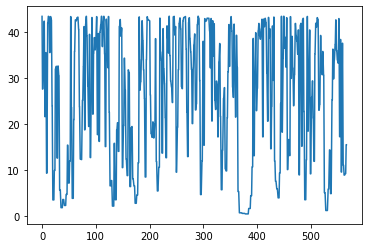

In [76]:
def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        print('x:', x, 'y:', y)
        print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            print('sol1:', sol1, 'sol2:', sol2)
            print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        print('ref:', ref, 'ref shape:', ref.shape)
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    print('t_left:',time_step[0], 't_right:',time_step[1], 
           't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            yf = -h
            vf = -v
            uf = u
            xf = x + u*time_step[di]
            #print('next wall: bottom')
    
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=1000)
plot_bill(res)


    


    


In [69]:

def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while k<5:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        print('x:', x, 'y:', y)
        print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            print('sol1:', sol1, 'sol2:', sol2)
            print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx != ty:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if x == sol1:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        print('ref:', ref, 'ref shape:', ref.shape)
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
semicircle_enclosure(x=-1.30463345, y=h , u=-0.70840413, v=0.70580705, t=0, lam=1, l=l, h=h, s=s, omega=omega)        

entered enclosure: x: -1.30463345 y: 1 u: -0.70840413 v: 0.70580705
x: -1.30463345 y: 1
disc: 25.12445421870378
sol1: -1.9076308139462042 sol2: 0.607789047199327
ysol1: 1.600786715634544 ysol2: -0.9054113661108811
first collision
p: -3.175221362761635
nor vec: [ 1.         -0.31493867]
ref: [[0.98501219]
 [0.17248476]] ref shape: (2, 1)
x: -1.9076308139462042 y: 1.600786715634544 vel_vec: [[0.98501219]
 [0.17248476]] m: [0.17510927]
x: -1.9076308139462042 y: 1.600786715634544
disc: [12.99497945]
sol1: [-1.90763081] sol2: [1.58997615]
ysol1: [1.60078672] ysol2: [2.21325011]
p: 1.3105097919922755
nor vec: [-1.         -0.76306183]
ref: [[-0.42642001]
 [-0.90452528]] ref shape: (2, 1)
x: [1.58997615] y: [2.21325011] vel_vec: [[-0.42642001]
 [-0.90452528]] m: [2.12120736]
x: [1.58997615] y: [2.21325011]
disc: [69.33996907]
sol1: [0.07583284] sol2: [1.58997615]
ysol1: [-0.99856183] ysol2: [2.21325011]
last collision
failed!: tx [1.34131145] ty [1.34131145]
exit enclosure: x: [1.0180141] y: 

(array([1.0180141]),
 1,
 array([-0.42642001]),
 array([-0.90452528]),
 array([5.74334285]))